In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pymc3 as pm
import theano.tensor as tt
import arviz
import warnings
warnings.simplefilter("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Basic Diagnostics

This is a quick overview to a few diagnostics:

- Traceplot
- Divergences
- Effective Sample Size
- r-hat

## Traceplot 

This is a simple plot that is a good quick check to make sure nothing is obviously wrong. We have done some work with step size tuning for Metropolis-Hastings, and that is a good jumping off point for a quiz on whether your step size is too small, too large, pretty good, or if it is actually independent samples: [quiz here](https://canyon289.github.io/bayesian-model-evaluation/lessonplans/mcmc_basics/#/14)

## Divergences

Hamiltonian Monte Carlo (NUTS is a flavor of this) does some numerical integration. When the integration goes wrong, it can go a lot wrong. This is sometimes considered a feature! There may be parts of the posterior which are hard to explore for geometric reasons. Two ways of solving divergences are

1. **Set a higher "target accept" rate**: Similarly (but not the same) as for Metropolis-Hastings, larger integrator steps lead to lower acceptance rates. A higher `target_accept` will generally cause a smaller step size, and more accurate integration.
2. **Reparametrize**: If you can write your model in a different way that has the same joint probability density, you might do that. A lot of work is being done to automate this, since it requires careful work, and one goal of a probabilistic programming language is to iterate quickly. See [Autoconj: Recognizing and Exploiting Conjugacy Without a Domain-Specific Language](https://arxiv.org/abs/1811.11926)(Hoffmann, Johnson, Tran), [Automatic Reparameterisation of Probabilistic Programs](https://arxiv.org/abs/1906.03028)(Gorinova, Moore, Hoffmann). There is work on this also in [symbolic pymc](https://github.com/pymc-devs/symbolic-pymc).

You should be wary of a trace that contains divergences, and give thought to how to fix them (though we all sometimes use those traces anyways).

### Divergence example

Neal's funnel is a famous example of a difficult geometry:

In [2]:
def neals_funnel(dims=1):
    with pm.Model() as funnel:
        v = pm.Normal('v', 0, 3)
        x_vec = pm.MvNormal('x_vec', mu=tt.zeros(dims), cov=2 * tt.exp(v) * tt.eye(dims), shape=dims)
    return funnel

with neals_funnel():
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: U

/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There 

/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/jointplot.py:149: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


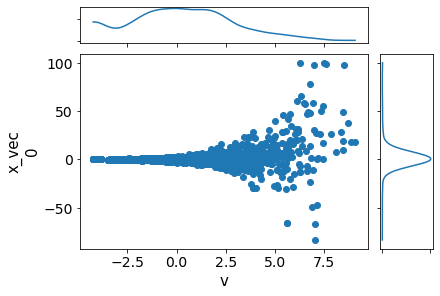

In [3]:
pm.plot_joint(trace);

## Effective Sample Size

Given a series of samples $x_j$, the empirical mean is

$$
\hat{\mu} = \frac{1}{n}\sum_{j=1}^n x_j
$$

and the variance of the estimate of the empirical mean is 

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n},
$$
where $\sigma^2$ is the true variance of the underlying distribution.

Then the effective sample size is defined as the denominator that makes this relationship still be true:

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n_{\text{eff}}}.
$$

This quantity is difficult to compute: you might use multiple chains to estimate $\operatorname{Var}(\hat{\mu})$, and estimating $\sigma^2$ is sort of the point of all this MCMC. There is a great recent paper giving details: [Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC](https://arxiv.org/abs/1903.08008)(Vehtari, Gelman, Simpson, Carpenter, Bürkner).

## $\hat{R}$

Roughly, $\hat{R}$ ("r-hat", "R-Hat", "Gelman-Rubin statistic") is the ratio of between-chain variance to within-chain variance. In practice, you compare a number of different measures of variance with eachother (first half of chain with second half, for example). This number should be *very* close to 1. Most libraries will let you know if it is not.

## Closing advice

Run at least 4 chains for your experiments, and pay attention to the indications your model had trouble fitting. These are problems with the inference algorithm, but now you have to worry about them!



In [4]:
pm.summary(trace)

/home/fonnesbeck/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v,0.496,2.590,-4.242,4.997,0.421,0.300,38.0,38.0,32.0,13.0,1.04
x_vec[0],0.972,9.361,-11.369,11.836,1.013,0.719,85.0,85.0,139.0,98.0,1.02


### Exercises

1. There are a few warnings PyMC3 throws with the funnel model. `pm.summary` recovers a few. There are methods on the `trace` object that let you find the others yourself.
2. Look up the centered eight schools model, and the non-centered eight schools model. The first had divergences, and the centering vs non-centering is a common reparameterization strategy
3. `plot_parallel` is a way to try to visualize where your divergences occur, so you might get a clue as to how to reparametrize. Also `traceplot` will mark the location of divergences.